In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.spatial as sp

from functools import reduce

In [2]:
def load_vocab(vocab_file):
    """
    Returns 3 dicts from vocab built with GloVe:
        - str2idx
        - idx2str
        - str2count
    str is token, idx is index given by glove, counts are total word count given by glove
    """
    # read vocab
    with open(vocab_file, 'r', encoding="utf-8") as f:
        vocab = []
        for line in f:
            vocab.append(line.strip())
    # create dicts
    str2idx = dict()
    idx2str = dict()
    str2count = dict()
    for i, word_and_count in enumerate(vocab):
        word, count = word_and_count.split()
        str2idx[word] = i+1
        idx2str[i+1] = word
        str2count[word] = int(count)
    return (str2idx, idx2str, str2count)


def similarity_by_pairs(M, indices, normalize=True):
    """
    Returns array with cosine similarity of pairs of indices of an array M
    Params:
        - matrix: np.array of shape dim x V
        - indices: tuple of len=2 with indices
        - normalize: use cosine similarity instead of dot
    """
    M_1 = M[:,indices[0]]
    M_2 = M[:,indices[1]]
    # para sparse PPMI:
    if scipy.sparse.issparse(M):
        # dot product de a pares
        similarities = M_1.multiply(M_2).sum(axis=0)
        similarities = np.asarray(similarities).ravel()
        if normalize:
            denominadores = scipy.sparse.linalg.norm(M_1, axis=0) * \
                                                scipy.sparse.linalg.norm(M_2, axis=0)
            similarities /= denominadores
    # para matrices dense WE
    else:
        # dot product de a pares (same as np.sum(a*b, axis=0))
        similarities = np.einsum('ij,ij->i', M_1.T, M_2.T) 
        if normalize:
            denominadores = np.linalg.norm(M_1, axis=0) * np.linalg.norm(M_2, axis=0)
            similarities /= denominadores
        
    return similarities.ravel()


def sample_idx_pairs(df, n_pairs, group_var, group_values):
    """
    Returns 2 lists A,B such that A[i],B[i] are samples of word pairs from df
    Params:
        - n_pairs: number of pairs to sample
        - group_var: name of variable that defines group
        - group_values: tuple of 2 groups from where to sample indices
    NOTE: puede haber pares repetidos (sucede cuando el grupo es chico)
    """
    df_1 = df.loc[df[group_var].isin([group_values[0]])]
    indices_1 = df_1['idx'].sample(n_pairs, replace=True).tolist()
    df_2 = df.loc[
        (df[group_var].isin([group_values[1]])) & (~df['idx'].isin(indices_1))]
    indices_2 = df_2['idx'].sample(n_pairs, replace=True).tolist()
    return indices_1, indices_2


def create_similarity_df(df, M, group_var, n_samples, normalize=True):
    """
    Returns df with similarities of sampled pairs for each combination
    of group_var values
    Param:
        - df: DataFrame of words and groups
        - M: matrix of vectors shape (dim, V)
        - n_samples: number of pairs of each combo to sample
        - normalize: use cosine similarity instead of dot prod
    """
    # cross join of DataFrame (all combos of group_freq)
    df_tmp = df[[group_var]].drop_duplicates().reset_index(drop=True)
    df_tmp['key'] = 0
    df_cross = pd.merge(df_tmp, df_tmp, how="outer", on="key")
    df_cross.drop(columns=['key'], inplace=True)
    df_cross['pairs'] = df_cross.apply(
        lambda d: sample_idx_pairs(
            df, n_samples, group_var, (d[group_var+'_x'], d[group_var+'_y']))
            , axis=1)
    df_cross['similarities'] = df_cross.apply(
        lambda d: similarity_by_pairs(M, d['pairs'], normalize=normalize), axis=1)
    df_cross['mean_similarity'] = df_cross['similarities'].apply(np.mean)
    return df_cross


def make_heatmap(df, group_var):
    """
    Make a crosstab and return a heatmap
    Param:
        - df: DataFrame with pairs and similarities
        - M: matrix with word vectors
        - group_var: name of variable that defines group
        - n_samples: number samples of pairs of words
        - normalize: use cosine similarity instead of dot prod
    """
    crosstab = df.pivot(
        index=group_var+'_x', columns=group_var+'_y', values='mean_similarity')
    crosstab.sort_index(level=0, ascending=False, inplace=True)
    ax = sns.heatmap(crosstab, cmap="viridis")
    ax.set(xlabel=group_var, ylabel=group_var)
    return ax


def join_pairs_dfs(df_w2v_dot, df_glove_dot, df_ppmi_dot
     , df_w2v_cosine, df_glove_cosine, df_ppmi_cosine):
    """
    Returns DFrame long with metrics for each pair of words
    """
    def turn_to_tuple_pairs(x):
        return tuple(zip(x[0], x[1]))
    df1 = df_w2v_dot.rename(
        columns={"similarities": "dot_w2v"}).drop(columns='mean_similarity')
    df2 = df_glove_dot.rename(
        columns={"similarities": "dot_glove"}).drop(columns='mean_similarity')
    df3 = df_ppmi_dot.rename(
        columns={"similarities": "dot_ppmi"}).drop(columns='mean_similarity')
    df4 = df_w2v_cosine.rename(
        columns={"similarities": "cosine_w2v"}).drop(columns='mean_similarity')
    df5 = df_glove_cosine.rename(
        columns={"similarities": "cosine_glove"}).drop(columns='mean_similarity')
    df6 = df_ppmi_cosine.rename(
        columns={"similarities": "cosine_ppmi"}).drop(columns='mean_similarity')
    dfs = [df1,df2,df3,df4,df5,df6]
    for i in range(len(dfs)):
        dfs[i]['pairs'] = dfs[i]['pairs'].apply(turn_to_tuple_pairs)
    df_tot = reduce(
        lambda a,b: pd.merge(a, b, on=['freq_order_x','freq_order_y','pairs'])
        , dfs)
    df_long = df_tot.set_index(
        ['freq_order_x','freq_order_y']).apply(pd.Series.explode).reset_index()
    return df_long.convert_dtypes()


def make_pairs_plt(df, columns, n_sample=None, seed=999):
    """
    Density plots in diagonales, scatter plots in lower diagonal
    Param:
        - df: df with metric for each pair of words
        - n_sample: rows to sample from df
    """
    # sample
    if n_sample:
        df = df.sample(n_sample, random_state=seed)
    n_columns = len(columns)
    fig, axs = plt.subplots(n_columns, n_columns, figsize=(8,8)
                            ,sharex=False, sharey=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, f1 in enumerate(columns):
        for j, f2 in enumerate(columns):
            if i == j:
                axs[i][j].hist(df[f2], 50, density=True, alpha=0.5)
                axs[i][j].axvline(0, ls='--', color='black', linewidth=0.5)
                axs[i][j].set_xlabel(f2)
            if i > j:
                axs[i][j].scatter(df[f2], df[f1], s=0.5)
                axs[i][j].axhline(0, ls='--', color='black', linewidth=0.5)
                axs[i][j].axvline(0, ls='--', color='black', linewidth=0.5)
                axs[i][j].set_xlabel(f2)
                axs[i][j].set_ylabel(f1)
    return fig, axs

## Data

In [3]:
# input files
vocab_file = "embeddings/vocab-C3-V20.txt"

w2v_file = "E:/tesis-BiasNLP/embeddings/w2v-C3-V20-W5-D100-SG1.npy"
glove_file = "E:/tesis-BiasNLP/embeddings/glove-C3-V20-W5-D1-D100-R0.05-E50-S1.npy"
pmi_file = "E:/tesis-BiasNLP/embeddings/pmi-C3-V20-W5-D0.npz"

In [4]:
# load vocab dicts
str2idx, idx2str, str2count = load_vocab(vocab_file)

In [5]:
%%time
# load WE matrices
M_w2v = np.load(w2v_file)
M_glove = np.load(glove_file)

Wall time: 4.77 s


In [6]:
%%time
# load PMI matrix
M_pmi = scipy.sparse.load_npz(pmi_file)

Wall time: 49 s


In [7]:
# Create Dframe of words and counts
df = pd.DataFrame.from_dict(str2count, orient='index').reset_index()
df.columns = ['word','freq']
df['idx'] = idx2str

In [8]:
# PPMI matrix
M_ppmi = M_pmi.maximum(0)
del M_pmi

## Frequency groups

In [9]:
bins = np.arange(1.25, 8.5, .25)
bins[bins > 5.5] = 8
bins = np.unique(bins)
df['freq_order'] = pd.cut(np.log10(df['freq']), bins=bins)

df['freq_order'].value_counts(dropna=False).sort_index()

(1.25, 1.5]    65843
(1.5, 1.75]    59575
(1.75, 2.0]    42847
(2.0, 2.25]    30476
(2.25, 2.5]    22355
(2.5, 2.75]    15690
(2.75, 3.0]    10909
(3.0, 3.25]     7728
(3.25, 3.5]     5510
(3.5, 3.75]     3996
(3.75, 4.0]     2773
(4.0, 4.25]     1908
(4.25, 4.5]     1298
(4.5, 4.75]      868
(4.75, 5.0]      493
(5.0, 5.25]      275
(5.25, 5.5]      141
(5.5, 8.0]       124
Name: freq_order, dtype: int64

In [10]:
n_quant = df['freq_order'].unique().size
df['freq_quant'] = pd.qcut(np.log10(df['freq']), n_quant, precision=1)

df['freq_quant'].value_counts(dropna=False).sort_index()

(1.29, 1.34]    21531
(1.34, 1.38]    11989
(1.38, 1.43]    15415
(1.43, 1.48]    12969
(1.48, 1.53]    14563
(1.53, 1.59]    14766
(1.59, 1.66]    16396
(1.66, 1.73]    14569
(1.73, 1.81]    14282
(1.81, 1.89]    15102
(1.89, 1.99]    15428
(1.99, 2.1]     15254
(2.1, 2.23]     14895
(2.23, 2.39]    15112
(2.39, 2.59]    15119
(2.59, 2.87]    15114
(2.87, 3.34]    15155
(3.34, 7.56]    15150
Name: freq_quant, dtype: int64

## Matrices de similitudes

Para cada combinación de grupos de frecuencias, se muestrean `N_SAMPLES` pares de palabras al azar, y se indica la similitud media de los pares. 

In [11]:
SEMILLA = 199
N_SAMPLES = 100

### Word2Vec

#### Dot product

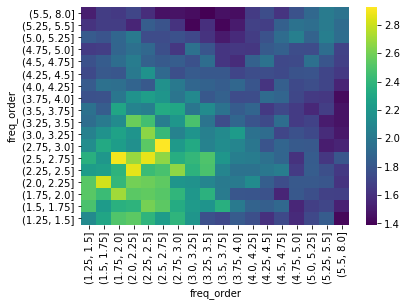

In [12]:
np.random.seed(SEMILLA)
df_w2v_dot = create_similarity_df(df, M_w2v, 'freq_order', n_samples=N_SAMPLES, normalize=False)
fig_ = make_heatmap(df_w2v_dot, 'freq_order')

#### Cosine

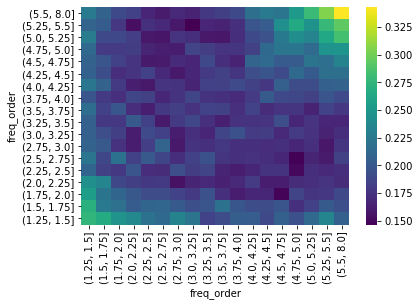

In [13]:
np.random.seed(SEMILLA)
df_w2v_cosine = create_similarity_df(df, M_w2v, 'freq_order', n_samples=N_SAMPLES, normalize=True)
fig_ = make_heatmap(df_w2v_cosine, 'freq_order')

### GloVe

#### Dot product

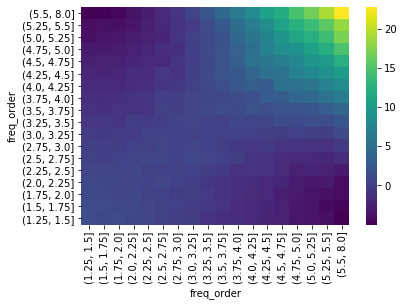

In [14]:
np.random.seed(SEMILLA)
df_glove_dot = create_similarity_df(df, M_glove, 'freq_order', n_samples=N_SAMPLES, normalize=False)
fig_ = make_heatmap(df_glove_dot, 'freq_order')

#### Cosine

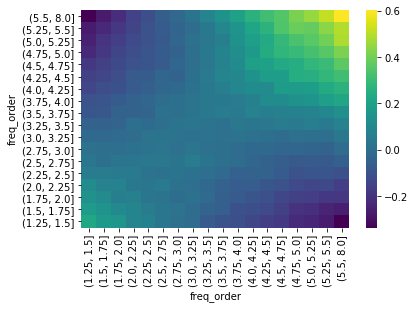

In [15]:
np.random.seed(SEMILLA)
df_glove_cosine = create_similarity_df(df, M_glove, 'freq_order', n_samples=N_SAMPLES, normalize=True)
fig_ = make_heatmap(df_glove_cosine, 'freq_order')

### PPMI_vec

#### Dot product

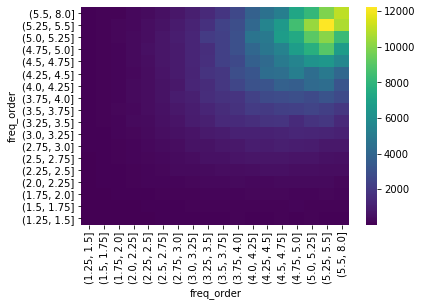

In [16]:
np.random.seed(SEMILLA)
df_ppmi_dot = create_similarity_df(
    df, M_ppmi, 'freq_order', n_samples=N_SAMPLES, normalize=False)
fig_ = make_heatmap(df_ppmi_dot, 'freq_order')

#### Cosine

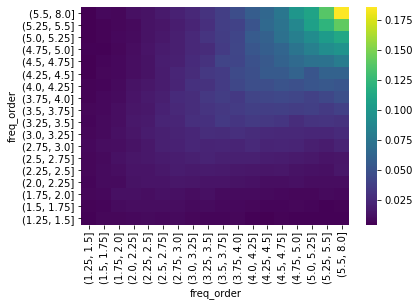

In [17]:
np.random.seed(SEMILLA)
df_ppmi_cosine = create_similarity_df(
    df, M_ppmi, 'freq_order', n_samples=N_SAMPLES, normalize=True)
fig_ = make_heatmap(df_ppmi_cosine, 'freq_order')

## Correlaciones

Para los pares de palabras usados en las matrices (`n_samples` por celda), se grafican las distribuciones univariadas y bivariadas de las métricas de similitud. 

In [18]:
df_pairs = join_pairs_dfs(df_w2v_dot, df_glove_dot, df_ppmi_dot
     , df_w2v_cosine, df_glove_cosine, df_ppmi_cosine)

### Dot product

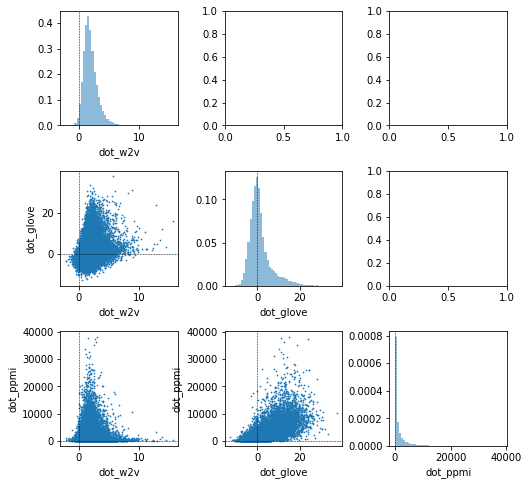

In [19]:
cols = ['dot_w2v','dot_glove','dot_ppmi']
fig_, ax_ = make_pairs_plt(df_pairs, cols)

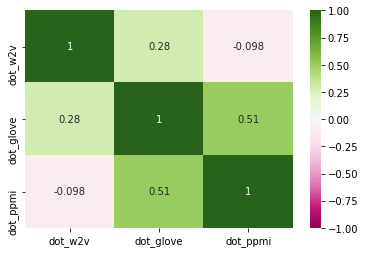

In [20]:
sns.heatmap(
    df_pairs[cols].corr("spearman"), vmin=-1, vmax=1, cmap="PiYG", annot=True)

### Cosine

In [21]:
cols = ['cosine_w2v','cosine_glove','cosine_ppmi']

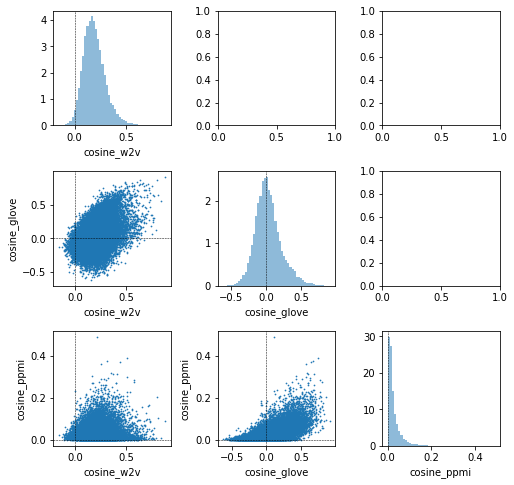

In [22]:
fig_, ax_ = make_pairs_plt(df_pairs, cols)

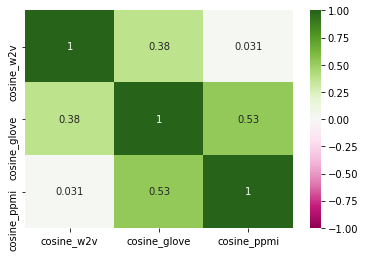

In [23]:
sns.heatmap(
    df_pairs[cols].corr("spearman"), vmin=-1, vmax=1, cmap="PiYG", annot=True)